# Two Moons: Tackling Bimodal Posteriors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8907
Minimum supported: 9100
Installed version: 8907
The local installation version must be no lower than 9100..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Simulator<a class="anchor" id="simulator"></a>

This example will demonstrate amortized estimation of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align}
$$

with $x = (x_1, x_2)$ playing the role of "observables" (data to be learned from), $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, and $r \sim \text{Normal}(0.1, 0.01)$ being latent variables creating noise in the data, and $\theta = (\theta_1, \theta_2)$ being the parameters that we will later seek to infer from new $x$. We set their priors to

$$
\begin{align}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1).
\end{align}
$$

This model is typically used for benchmarking simulation-based inference (SBI) methods (see https://arxiv.org/pdf/2101.04653) and any method for amortized Bayesian inference should be capable of recovering the two moons posterior *without* using a gazillion of simulations. Note, that this is a considerably harder task than modeling the common unconditional two moons data set used often in the context of normalizing flows.

BayesFlow offers many ways to define your data generating process. Here, we use sequential functions to build a simulator object for online training. Within this composite simulator, each function has access to the outputs of the previous functions. This effectively allows you to define any generative graph.

In [2]:
def alpha_prior():
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    return dict(alpha=alpha)

def r_prior():
    r = np.random.normal(0.1, 0.01)
    return dict(r=r)

def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta, alpha, r):
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

Within the composite simulator, every simulator has access to the outputs of the previous simulators in the list. For example, the last simulator `forward_model` has access to the outputs of the three other simulators.

In [3]:
simulator = bf.simulators.CompositeLambdaSimulator([alpha_prior, r_prior, theta_prior, forward_model])

Let's generate some data to see what the simulator does:

In [4]:
# generate 128 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample((128,))

In [5]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['alpha', 'r', 'theta', 'x'])
Types of sample_data values:
	 {'alpha': <class 'numpy.ndarray'>, 'r': <class 'numpy.ndarray'>, 'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'alpha': (128, 1), 'r': (128, 1), 'theta': (128, 2), 'x': (128, 2)}


BayesFlow also provides this simulator and a collection of others in the `bayesflow.benchmarks` module.

## Data Adapter

The next step is to tell BayesFlow how to deal with all the simulated variables. You may also think of this as informing BayesFlow about the data flow, i.e., which variables go into which network.

For this example, we want to learn the posterior distribution $p(\theta | x)$, so we **infer** $\theta$, **conditioning** on $x$.

In [6]:
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["theta"],
    inference_conditions=["x"],
)

## Dataset

For this example, we will sample our training data ahead of time and use offline training with a `bf.datasets.OfflineDataset`.

This makes the training process faster, since we avoid repeated sampling. If you want to use online training, you can use an `OnlineDataset` analogously, or just pass your simulator directly to `approximator.fit()`!

In [7]:
num_training_batches = 1024
num_validation_batches = 256
batch_size = 128

In [8]:
training_samples = simulator.sample((num_training_batches * batch_size,))
validation_samples = simulator.sample((num_validation_batches * batch_size,))

In [9]:
training_dataset = bf.datasets.OfflineDataset(training_samples, batch_size=batch_size, data_adapter=data_adapter)
validation_dataset = bf.datasets.OfflineDataset(validation_samples, batch_size=batch_size, data_adapter=data_adapter)

## Traing a neural network to approximate all posteriors

The next step is to set up the neural network that will approximate the posterior $p(\theta|x)$.

We choose Flow Matching as the architecture for this example, as it can deal well with the multimodal nature of the posteriors that some observables imply.

In [10]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)

This inference network is just a general Flow Matching architecture, not yet adapted to the specific inference task at hand (i.e., posterior appproximation). To achieve this adaptation, we combine the network with our data adapter, which together form an `approximator`. In this case, we need a `ContinuousApproximator` since the target we want to approximate is the posterior of the *continuous* parameter vector $\theta$.

In [11]:
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

### Optimizer and Learning Rate
For this example, it is sufficient to use a static learning rate. In practice, you may want to use a learning rate schedule, like [cosine decay](https://keras.io/api/optimizers/learning_rate_schedules/cosine_decay/).

In [12]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
approximator.compile(optimizer=optimizer)

### Training

We are ready to train our deep posterior approximator on the two moons example. We pass the dataset object to the `fit` method and watch as Bayesflow trains.

In [14]:
history = approximator.fit(
    epochs=30,
    dataset=training_dataset,
    validation_data=validation_dataset,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.6938 - loss/inference_loss: 0.6938 - val_loss: 0.5508 - val_loss/inference_loss: 0.5508
Epoch 2/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6250 - loss/inference_loss: 0.6250 - val_loss: 0.6023 - val_loss/inference_loss: 0.6023
Epoch 3/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6056 - loss/inference_loss: 0.6056 - val_loss: 0.4454 - val_loss/inference_loss: 0.4454
Epoch 4/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6006 - loss/inference_loss: 0.6006 - val_loss: 0.5079 - val_loss/inference_loss: 0.5079
Epoch 5/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6020 - loss/inference_loss: 0.6020 - val_loss: 0.5414 - val_loss/inference_loss: 0.5414
Epoch 6/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5973 - loss/inference_loss: 0.5973 - val_loss: 0.6961 - val_loss/inference_loss: 0.6961
Epoch 7/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5874 - loss/inference_lo

## Validation

### Two Moons Posterior

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density. 
These results suggest that our flow matching setup can approximate the expected analytical posterior well. (Note that you can achieve an even better fit if you use online training and more epochs.)

(-0.5, 0.5)

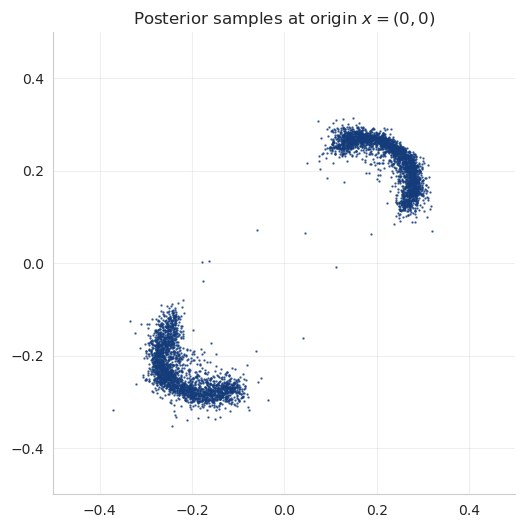

In [15]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Obtain samples from amortized posterior
conditions = {"x": np.array([[0.0, 0.0]]).astype("float32")}
samples_at_origin = approximator.sample(conditions=conditions, num_samples=num_samples)["theta"]

# Prepare figure
f, axes = plt.subplots(1, figsize=(6, 6))

# Plot samples
axes.scatter(samples_at_origin[0, :, 0], samples_at_origin[0, :, 1], color="#153c7a", alpha=0.75, s=0.5)
sns.despine(ax=axes)
axes.set_title(r"Posterior samples at origin $x=(0, 0)$")
axes.grid(alpha=0.3)
axes.set_aspect("equal", adjustable="box")
axes.set_xlim([-0.5, 0.5])
axes.set_ylim([-0.5, 0.5])


The posterior looks as we have expected in this case. However, in general, we do not know how the posterior is supposed to look like for any specific dataset. As such, we need diagnostics that validate the correctness of the inferred posterior. One such diagnostic is simulation-based calibration(SBC), which we can apply for free due to amortization. For more details on SBC and diagnostic plots, see:

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. *arXiv preprint*.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. *Statistics and Computing*.

In [16]:
# Will be added soon.

## Further Experimentation <a class="anchor" id="further_experimentation"></a>

In [17]:
# Will be added soon.